In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import scipy.stats as st
import statsmodels.api as sm

from PIL import Image
from sklearn.covariance import ledoit_wolf, oas

# Settings
%matplotlib inline
matplotlib.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{mathtools}')
matplotlib.rcParams["figure.facecolor"] = "white"
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

# Global variables
save_fig = lambda x : plt.savefig("../figs/" + x, bbox_inches='tight')

# Aesthetic
end = '\033[0m'
bold = '\033[1m'
header = "===================================="
n_spaces = 3

def print_results(dictionary):
    max_length = max(map(lambda x: len(x.replace("\n", "")), dictionary))
    for key in dictionary:
        if key[-1] == "\n":
            print(bold + str(key) + end + str(dictionary[key]))
        else:
            spaces_aux = n_spaces + (max_length - len(key.replace("\n", "")))
            spaces = " " * spaces_aux
            print(bold + str(key) + end + spaces + str(dictionary[key]))


In [63]:
data = np.random.multivariate_normal([0, 0], np.array([[5, 3/2], [3/2, 3]]), size=1000)
u, v = data[:, 0], data[:, 1]

prod = (u*v).sum()
u_norm = np.linalg.norm(u)
v_norm = np.linalg.norm(v)

aux = prod / (u_norm * v_norm)
rho = np.corrcoef(u, v)[0, 1]
print(aux)
print(rho)
print(abs(aux - rho))

0.43894601347232726
0.43894776729438156
1.7538220543067418e-06


In [2]:
def compress_image(u, s, vh, n_lambda, r_all=True):
    if r_all:
        matrices = []
    acum = np.zeros((u.shape[0], vh.shape[1]))
    for i in range(n_lambda):
        u_aux = np.reshape(u[:, i], (u.shape[0], 1))
        v_aux = np.reshape(vh[i, :], (1, vh.shape[0]))
        acum += u_aux.dot(v_aux) * s[i]
        if r_all:
            matrices.append(acum.copy())

    if r_all:
        return matrices
    else:
        return acum


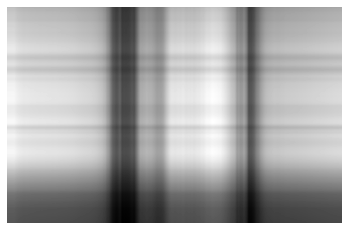

In [41]:
picture = np.array(Image.open("photo.jpg").convert("L"))
u, s, vh = np.linalg.svd(picture)

# Plotting the first 4 images
image = compress_image(u, s, vh, 1, r_all=False)
plt.imshow(image, cmap='gray')
plt.axis('off')
save_fig("exercise-2-svd-1.jpg")
plt.show()


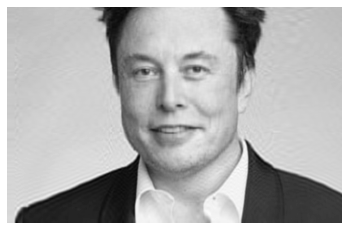

In [40]:
image = compress_image(u, s, vh, 50, r_all=False)
plt.imshow(image, cmap='gray')
plt.axis('off')
save_fig("exercise-2-svd-50.jpg")
plt.show()


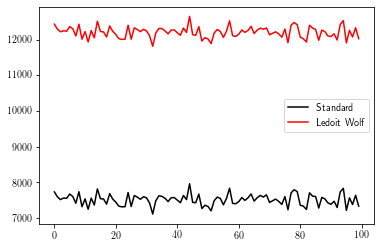

In [59]:
# Correlation to covariance
def corr_to_cov(data, correlation):
    stds = data.std(axis=0, ddof=1)
    cov = np.zeros(correlation.shape)
    for i in range(correlation.shape[0]):
        for j in range(correlation.shape[1]):
            cov[i, j] = correlation[i, j] * stds[i] * stds[j]
    return cov
corr = lambda x,y: corr_to_cov(x, pd.DataFrame(x).corr(method=y).to_numpy())

def get_mixture():
    # Means
    mu1, mu2 = np.array([0, 0]), np.array([100, 100])

    # Covariances
    cov1 = np.array([[3, 0], [0, 1]])

    # Data
    data1 = np.random.multivariate_normal(mu1, cov1, size=3000)
    data2 = np.random.multivariate_normal(mu2, cov1, size=1000)

    # Mixture
    return np.concatenate((data1, data2))

# Calculate variances
vars_normal = []
vars_robust = []
for i in range(100):
    mixture = get_mixture()
    vars_normal.append(np.linalg.det(np.cov(mixture.T)))
    vars_robust.append(np.linalg.det(ledoit_wolf(mixture)[0]))

plt.plot(vars_normal, 'k', label='Standard')
plt.plot(vars_robust, 'r', label='Ledoit Wolf')
plt.legend()
save_fig("exercise-4.pdf")
plt.show()


In [16]:
file = open("portfolio100.txt").readlines()
data = []
for line in file:
    row = []
    acum = ""
    for char in line:
        if char != " ":
            acum += char
        if char == " " and len(acum) != 0:
            row.append(float(acum))
            acum = ""
    if acum != "":
        row.append(float(acum))
    data.append(row)

data_port = np.array(data, dtype=float)[:, :10]


In [27]:
def invariant(trans, fig_name, val, n_max=100):
    ns = np.array(range(2, n_max))
    norms = np.zeros((2, n_max - 2))
    for n in ns:
        A = np.random.uniform(low=-2, high=2, size=trans.shape)
        norms[0, n - 2] = np.linalg.norm(A, ord='fro')
        norms[1, n - 2] = np.linalg.norm(A @ trans, ord='fro')

    plt.scatter(norms[0, :], norms[1, :], s=5, c='k')
    plt.xlabel("$\lVert A \lVert_{F}$")
    plt.ylabel("$\lVert A\Theta_" + str(val) + " \lVert_{F}$")
    save_fig(fig_name)
    plt.clf()

# Theta
theta = np.pi / 3
trans = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
invariant(trans, "exercise-5-sin.pdf", 1)

# Reflection across x-axis
trans = np.array([[1, 0],
                  [0, -1]])
invariant(trans, "exercise-5-reflection.pdf", 2)

# Permutation of coordinate axis
trans = np.array([[0, 0, 0, 1],
                  [0, 0, 1, 0],
                  [1, 0, 0, 0],
                  [0, 1, 0, 0]])
invariant(trans, "exercise-5-perm.pdf", 3)


<Figure size 432x288 with 0 Axes>

In [30]:
A = sc.linalg.hilbert(50)
b = data_port[:50, :1]

# Inverse
x_inv = np.linalg.inv(A) @ b
b_inv = A @ x_inv
d_inv = np.linalg.norm(b_inv - b, ord='fro')

# Pseudo-inverse
x_pinv = np.linalg.pinv(A) @ b
b_pinv = A @ x_pinv
d_pinv = np.linalg.norm(b_pinv - b, ord='fro')

# LU
P, L, U = sc.linalg.lu(A)
y_lu = np.linalg.pinv(P @ L) @ b
x_lu = np.linalg.pinv(U) @ y_lu
b_lu = A @ x_lu
d_lu = np.linalg.norm(b_lu - b, ord='fro')

# QR decomposition
Q, R = np.linalg.qr(A)
y_qr = Q.T @ b
x_qr = np.linalg.pinv(R) @ y_qr
b_qr = A @ x_qr
d_qr = np.linalg.norm(b_qr - b, ord='fro')

# Printing results
print(header)
print("            Distance to real solution")

results = {"Inverse solution =": d_inv,
           "Pseudo-inverse solution =": d_pinv,
           "LU solution =": d_lu,
           "QR solution =": d_qr}
print_results(results)


            Distance to real solution
Inverse solution =          1072087.3959603293
Pseudo-inverse solution =   136.62724452430533
LU solution =               163.48076644833532
QR solution =               117.14632785038529


In [39]:
# Simulating X_i
xs = []
aux = np.zeros(1000)
for i in range(1, 6):
    xs.append(np.random.normal(loc=i**2, scale=1, size=1000))
    aux += (2 + 3*i) / i * xs[-1]

# Creating eps and y
eps = np.random.normal(scale=0.5, size=1000)
y = aux + eps

# Pseudo inverse
A = np.array(xs)
invA = np.linalg.pinv(A)
coeffs0 = y @ invA

# Printing results
results = sm.OLS(y, A.T).fit()
coeffs = results.params
results = {"Pseudo-inverse =": coeffs0,
           "Regression model coeffs =": coeffs,
           "Distance =": np.linalg.norm(coeffs0 - coeffs)}
print(header)
print_results(results)


Pseudo-inverse =            [4.99405241 3.99773449 3.66577647 3.50088374 3.40351005]
Regression model coeffs =   [4.99405241 3.99773449 3.66577647 3.50088374 3.40351005]
Distance =                  1.1402201262791843e-13
